# Getting Started With DESC

DESC is a 3D MHD equilibrium and optimization code suite, which solves the ideal MHD equilibrium equations to find stellarator equilibria. 

Like VMEC, DESC requires 4 main inputs to define the equilibrium problem:

 - Pressure Profile
 - Rotational Transform Profile
 - Last Closed Flux Surface Boundary Shape
 - Total toroidal magnetic flux enclosed by the LCFS

DESC can be run both with a text input file from the command line (e.g. `python -m desc INPUT_FILE`) or through python scripts (which offers more options than the text file for equilibrium solving and optimization). This tutorial notebook will focus on running from the command line.

## Installing DESC

The installation instructions are located in the [installation documentation page](https://desc-docs.readthedocs.io/en/latest/installation.html#installation).

Once these instructions are followed and DESC is installed correctly, you should be able to import a module from desc such as `desc.io` without any errors.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

In [2]:
import desc.io

## Running DESC On HELIOTRON Example Case

We could run a HELIOTRON case from a DESC input file directly, but let's first see how to convert a VMEC input file to a [DESC input file](https://desc-docs.readthedocs.io/en/latest/input.html#input-file).

In this directory is an `input.HELIOTRON` VMEC file which contains a finite beta HELIOTRON fixed boundary stellarator. To convert the input, we simply run DESC from the command line with

`python -m desc -vv input.HELIOTRON -o HELIOTRON_output.h5`.

You can leave out `python -m` if you've added DESC to your python path. The `-vv` flag is for double verbosity. The `-o` flag specifies the filename of the output HDF5 file (`XXX_output.h5` by default). See the [command line docs](https://desc-docs.readthedocs.io/en/latest/command_line.html#command-line-interface) for more information.

The conversion creates a new file with `_desc` appended to the file name. The above command automatically converts the VMEC input file to a DESC input file and begins solving it. However, there are many DESC solver options without VMEC analogs, so this automatic conversion may not result in a great solution. It is recommended to review the DESC input file and consider modifying the solver options to allow for better convergence to an equilibrium solution.

Generally, the most important parameters to tweak are related to the spectral resolution and the continuation method. DESC leverages a multi-grid continuation method to allow for robust convergence of highly shaped equilibria. The following parameters control this method:

### Spectral Resolution
 
- `L_rad` (int): Maximum radial mode number for the Fourier-Zernike basis.
    - default = `M_pol` if `spectral_indexing = ANSI`
    - default = `2*M_pol` if `spectral_indexing = Fringe`
    - For more information see [Basis functions and collocation nodes](https://desc-docs.readthedocs.io/en/latest/notebooks/basis_grid.html).
- `M_pol` (int): Maximum poloidal mode number for the Fourier-Zernike basis. **Required input.**
- `N_tor` (int): Maximum toroidal mode number for the Fourier-Zernike basis.
    - default = 0
- `L_grid` (int): Radial resolution of nodes in collocation grid.
    - default = `M_grid` if `spectral_indexing = ANSI`
    - default = `2*M_grid` if `spectral_indexing = Fringe`
- `M_grid` (int): Poloidal resolution of nodes in collocation grid.
    - default = `2*M_pol`
- `N_grid` (int): Toroidal resolution of nodes in collocation grid.
    - default = `2*N_tor`

When `M_grid = M_pol`, the number of collocation nodes in each toroidal cross-section is equal to the number of Zernike polynomials in the basis set. When `N_grid = N_tor`, the number of nodes with unique toroidal angles is equal to the number of terms in the toroidal Fourier series. Convergence is typically superior when the number of nodes exceeds the number of spectral coefficients, but this adds computational cost.

These arguments can be passed as arrays, where each element denotes the value to use at that iteration. Array elements are delimited by either a space, comma `,` , or semicolon `;`. Arrays can also be created using the shorthand notation `start:interval:end` and `(value)x(repititions)`. For example, an input line of `M_pol = 6:2:10, 10; 11x2 12` is equivalent to `M_pol = 6, 8, 10, 10, 11, 11, 12`.

### Continuation Method

- `pres_ratio` (float): Multiplier on the pressure profile. Default = `1.0`.
- `bdry_ratio` (float): Multiplier on the 3D boundary modes. Default = `1.0`.
- `pert_order` (int): Order of the perturbation approximation: `0` = no perturbation, `1` = linear, `2` = quadratic. Default = `1`.

When `pres_ratio = 1` and `bdry_ratio = 1`, the equilibrium is solved using the exact boundary modes and pressure profile as input. `pres_ratio = 0` assumes a vanishing beta pressure profile. `bdry_ratio = 0` ignores all the non-axisymmetric boundary modes (reducing the input to a tokamak).

These arguments are also passed as arrays for each iteration, with the same notation as the other continuation parameters. This example will start by solving a vacuum tokamak, then perturb the pressure profile to solve a finite-beta tokamak, and finally perturb the boundary to solve the finite-beta stellarator. If only one value is given, as with `pert_order` in this example, that value will be used for all iterations.

In general, we can design an input to use a 3-step continuation method:

1. Solve a zero beta (`pres_ratio=0`) axisymmetric tokamak (`bdry_ratio=0`), which will use only the axisymmetric modes of the boundary. Let's choose a radial and poloidal resolution of `L_rad=6` and `M_pol=6`, and since it is axisymmetric we can use no toroidal resolution: `N_tor=0`. We'll also choose collocation grid resolutions that are twice our spectral resolutions: `L_grid=12`, `M_grid=12`, `N_grid=0`.
2. Solve a finite-beta tokamak (`pres_ratio=1`) and increment our radial and poloidal resolutions by one: `L_rad=8`, `M_pol=8`, `N_tor=0` and the corresponding grid resolutions: `L_grid=16`, `M_grid=16`, `N_grid=0`.
3. Add in the non-axisymmetric modes and solve the full stellarator by setting `bdry_ratio=1` and adding toroidal resolution: `N_tor=3`, `N_grid=6`.

As a visual, these modifications would change the input file below to the one following it.

#### Without 3-step continuation method
```
# global parameters 
sym = 1 
NFP = 19 
Psi = 1.0 

# spectral resolution 
L_rad = 12 
M_pol = 12 
N_tor = 3 
L_grid = 24 
M_grid = 24 
N_grid = 6 

# continuation parameters 
bdry_ratio = 1
pres_ratio = 1
pert_order = 1

# solver tolerances 
ftol = 0.01 
xtol = 1e-06 
gtol = 1e-06 
nfev = 0 

# solver methods
optimizer = lsq-exact
objective = force
bdry_mode = lcfs
spectral_indexing = ansi
node_pattern = jacobi

# pressure and rotational transform/current profiles
l:   0	p =   1.80000000E+04	i =   1.00000000E+00
l:   2	p =  -3.60000000E+04	i =   1.50000000E+00
l:   4	p =   1.80000000E+04	i =   0.00000000E+00

# fixed-boundary surface shape
l:   0	m:   0	n:   0	R1 =   1.00000000E+01	Z1 =   0.00000000E+00
l:   0	m:   1	n:   0	R1 =  -1.00000000E+00	Z1 =   0.00000000E+00
l:   0	m:   0	n:   1	R1 =   0.00000000E+00	Z1 =   0.00000000E+00
l:   0	m:   1	n:   1	R1 =  -3.00000000E-01	Z1 =   0.00000000E+00
l:   0	m:  -1	n:  -1	R1 =   3.00000000E-01	Z1 =   0.00000000E+00
l:   0	m:  -1	n:   0	R1 =   0.00000000E+00	Z1 =   1.00000000E+00
l:   0	m:   0	n:  -1	R1 =   0.00000000E+00	Z1 =   0.00000000E+00
l:   0	m:  -1	n:   1	R1 =   0.00000000E+00	Z1 =  -3.00000000E-01
l:   0	m:   1	n:  -1	R1 =   0.00000000E+00	Z1 =  -3.00000000E-01

# magnetic axis initial guess
n:   0	R0 =   1.00000000E+01	Z0 =   0.00000000E+00
```

#### With 3-step continuation method
```
# global parameters 
sym = 1 
NFP = 19 
Psi = 1.00000000

# spectral resolution 
L_rad =   6, 12
M_pol =   6, 12
N_tor =   0,  0, 3
L_grid = 12, 24
M_grid = 12, 24
N_grid =  0,  0, 6

# continuation parameters 
bdry_ratio = 0, 0, 1 
pres_ratio = 0, 1
pert_order = 1

# solver tolerances 
ftol = 0.01 
xtol = 1e-06 
gtol = 1e-06 
nfev = 0 

# solver methods
optimizer = lsq-exact
objective = force
bdry_mode = lcfs
spectral_indexing = ansi
node_pattern = jacobi

# pressure and rotational transform/current profiles
l:   0	p =   1.80000000E+04	i =   1.00000000E+00
l:   2	p =  -3.60000000E+04	i =   1.50000000E+00
l:   4	p =   1.80000000E+04	i =   0.00000000E+00

# fixed-boundary surface shape
l:   0	m:   0	n:   0	R1 =   1.00000000E+01	Z1 =   0.00000000E+00
l:   0	m:   1	n:   0	R1 =  -1.00000000E+00	Z1 =   0.00000000E+00
l:   0	m:   0	n:   1	R1 =   0.00000000E+00	Z1 =   0.00000000E+00
l:   0	m:   1	n:   1	R1 =  -3.00000000E-01	Z1 =   0.00000000E+00
l:   0	m:  -1	n:  -1	R1 =   3.00000000E-01	Z1 =   0.00000000E+00
l:   0	m:  -1	n:   0	R1 =   0.00000000E+00	Z1 =   1.00000000E+00
l:   0	m:   0	n:  -1	R1 =   0.00000000E+00	Z1 =   0.00000000E+00
l:   0	m:  -1	n:   1	R1 =   0.00000000E+00	Z1 =  -3.00000000E-01
l:   0	m:   1	n:  -1	R1 =   0.00000000E+00	Z1 =  -3.00000000E-01

# magnetic axis initial guess
n:   0	R0 =   1.00000000E+01	Z0 =   0.00000000E+00
```

#### Auto generated input
Conveniently for us, DESC added a similar continuation method when converting the VMEC input.

```
# This DESC input file was auto generated from the VMEC input file
# For details on the various options see https://desc-docs.readthedocs.io/en/stable/input.html

# global parameters
sym = 1 
NFP =  19 
Psi = 1.00000000 

# spectral resolution
L_rad = 6, 12, 12, 12, 12, 12, 12, 12
M_pol = 12, 12, 12, 12, 12, 12, 12, 12
N_tor = 0, 0, 0, 0, 3, 3, 3, 3
L_grid = 12, 24, 24, 24, 24, 24, 24, 24
M_grid = 24, 24, 24, 24, 24, 24, 24, 24
N_grid = 0, 0, 0, 0, 6, 6, 6, 6

# continuation parameters
bdry_ratio = 0, 0, 0, 0, 0.25, 0.5, 0.75, 1.0 
pres_ratio = 0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0 
curr_ratio = 0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0 
pert_order = 1, 1, 2, 2, 2, 2, 2, 2 

# solver tolerances
ftol = 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01
xtol = 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06
gtol = 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06
nfev = 50, 50, 50, 50, 50, 50, 50, 50

# solver methods
optimizer = lsq-exact
objective = force
bdry_mode = lcfs
spectral_indexing = ansi
node_pattern = jacobi

# pressure and rotational transform/current profiles
l:   0	p =   1.80000000E+04	i =   1.00000000E+00
l:   2	p =  -3.60000000E+04	i =   1.50000000E+00
l:   4	p =   1.80000000E+04	i =   0.00000000E+00

# fixed-boundary surface shape
l:   0	m:   0	n:   0	R1 =   1.00000000E+01	Z1 =   0.00000000E+00
l:   0	m:   1	n:   0	R1 =  -1.00000000E+00	Z1 =   0.00000000E+00
l:   0	m:   0	n:   1	R1 =   0.00000000E+00	Z1 =   0.00000000E+00
l:   0	m:   1	n:   1	R1 =  -3.00000000E-01	Z1 =   0.00000000E+00
l:   0	m:  -1	n:  -1	R1 =   3.00000000E-01	Z1 =   0.00000000E+00
l:   0	m:  -1	n:   0	R1 =   0.00000000E+00	Z1 =   1.00000000E+00
l:   0	m:   0	n:  -1	R1 =   0.00000000E+00	Z1 =   0.00000000E+00
l:   0	m:  -1	n:   1	R1 =   0.00000000E+00	Z1 =  -3.00000000E-01
l:   0	m:   1	n:  -1	R1 =   0.00000000E+00	Z1 =  -3.00000000E-01

# magnetic axis initial guess
n:   0	R0 =   1.00000000E+01	Z0 =   0.00000000E+00
```

#### Loading the results

DESC provides utility functions to load and compare equilibria. These will be covered in detail later in the tutorial. For now, notice that DESC saves solutions as `EquilibriaFamily` objects. An `EquilibriaFamily` is essentially a list of equilibria, which can be indexed to retrieve individual equilibria. Higher indices hold equilibria solved later in the continuation process. You can retrieve the final state of a DESC equilibrium solve with `eq = desc.io.load("XXX_output.h5")[-1]`.

In [3]:
%matplotlib inline
from desc.plotting import plot_comparison, plot_section

DESC version 0.7.2+334.g1fe6b36e.dirty,using JAX backend, jax version=0.4.1, jaxlib version=0.4.1, dtype=float64
Using device: CPU, with 10.27 GB available memory


Number of equilibria in the EquilibriaFamily: 8


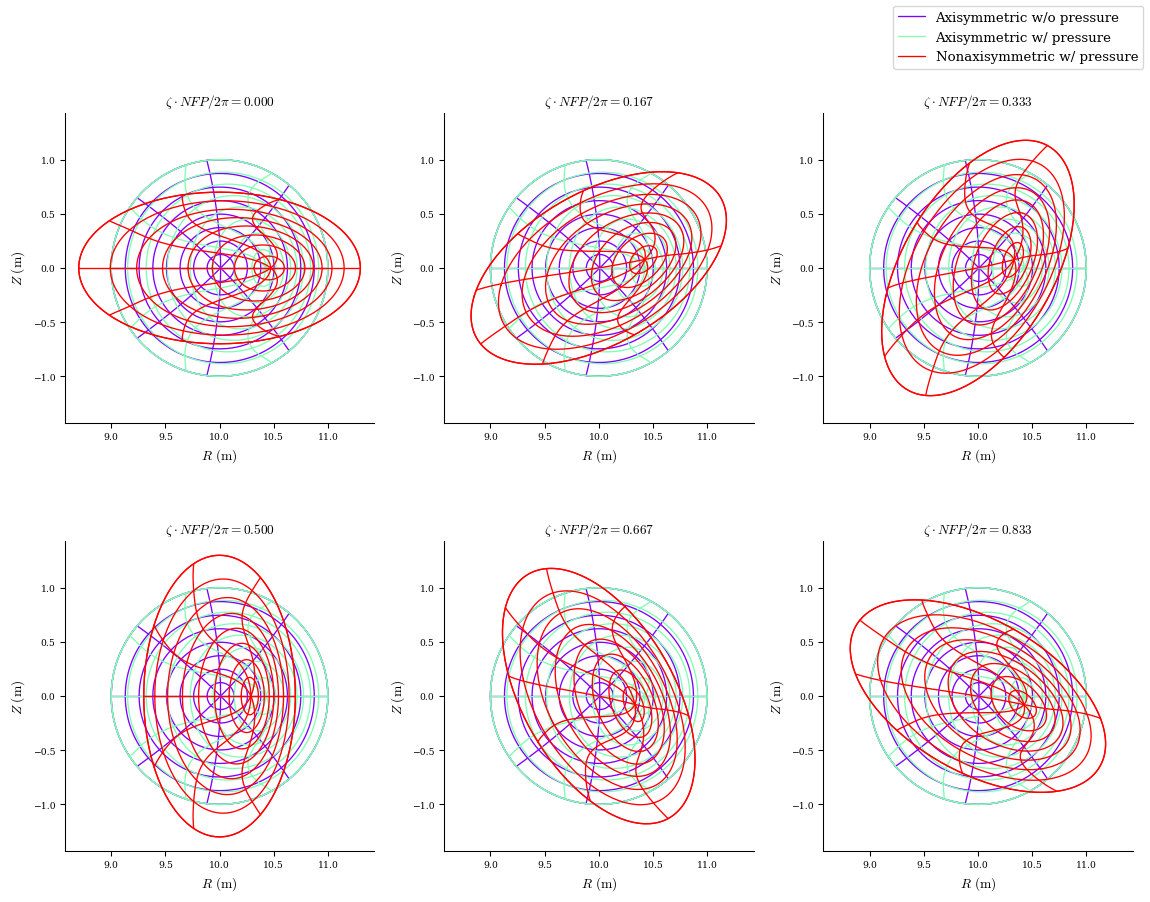

In [4]:
eq_fam = desc.io.load("HELIOTRON_output.h5")
print("Number of equilibria in the EquilibriaFamily:", len(eq_fam))
fig, ax = plot_comparison(
    eqs=[eq_fam[1], eq_fam[3], eq_fam[-1]],
    labels=[
        "Axisymmetric w/o pressure",
        "Axisymmetric w/ pressure",
        "Nonaxisymmetric w/ pressure",
    ],
)

Let's continue the tutorial by comparing the final equilibria that result from the

- first input file which lacks a continuation method
- last input file which was auto generated by DESC

#### Flux surface comparison

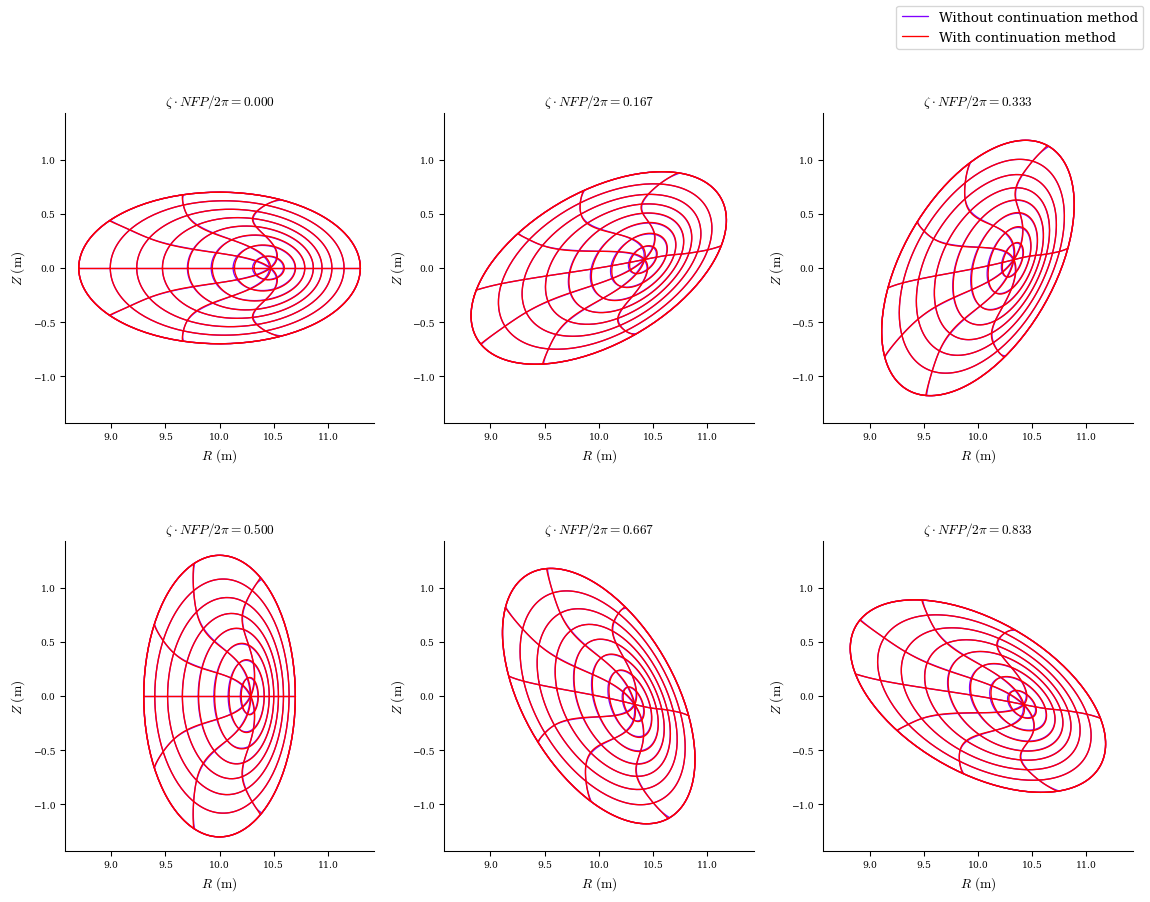

In [5]:
eq_fam_no_continuation = desc.io.load("HELIOTRON_no_continuation_output.h5")
plot_comparison(
    eqs=[eq_fam_no_continuation[-1], eq_fam[-1]],
    labels=["Without continuation method", "With continuation method"],
);

#### Force error plot comparison

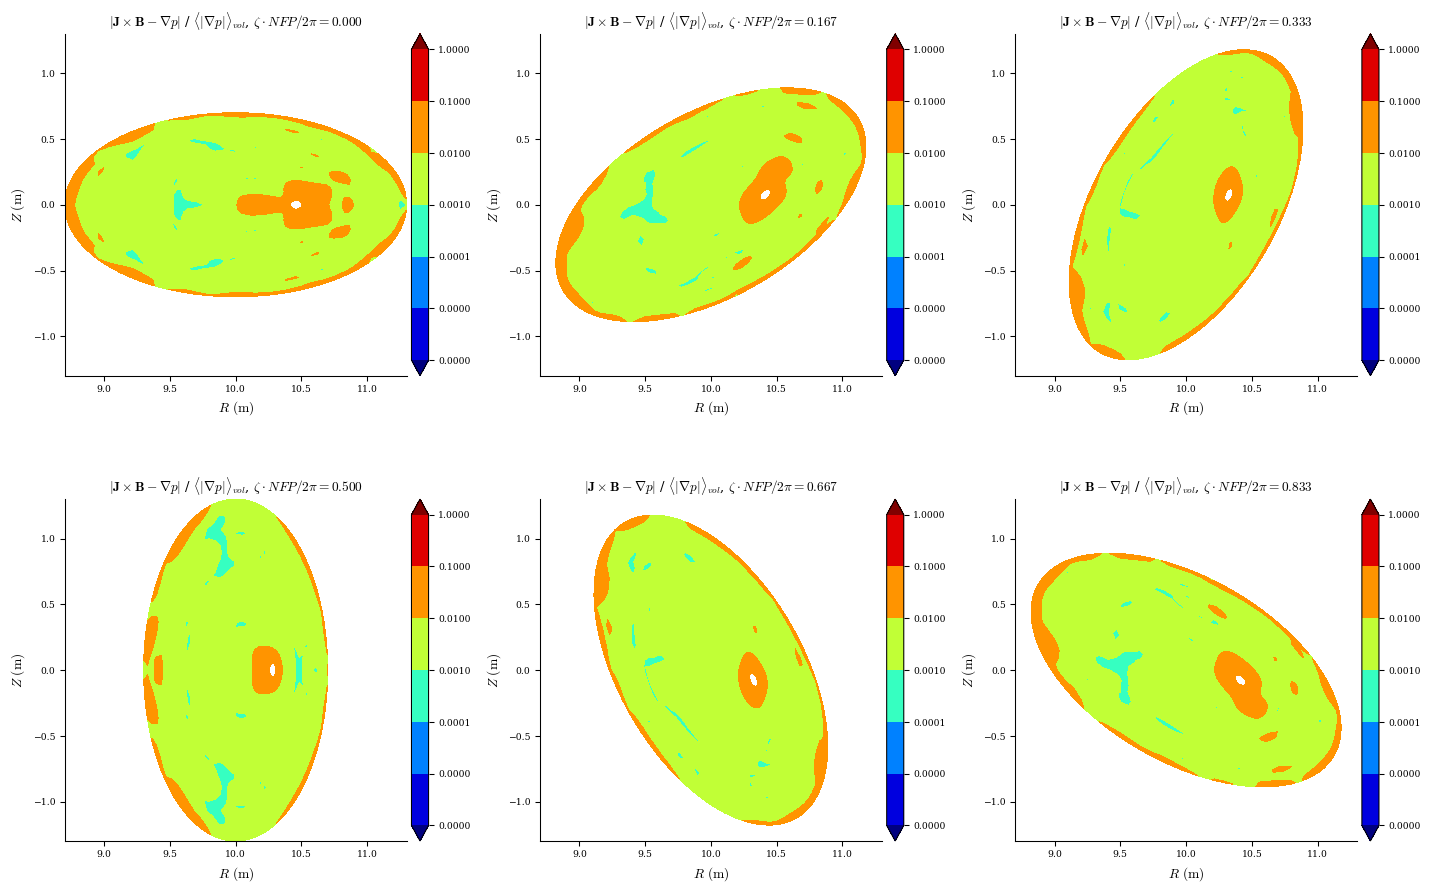

In [6]:
plot_section(eq_fam_no_continuation[-1], name="|F|", log=True, norm_F=True);

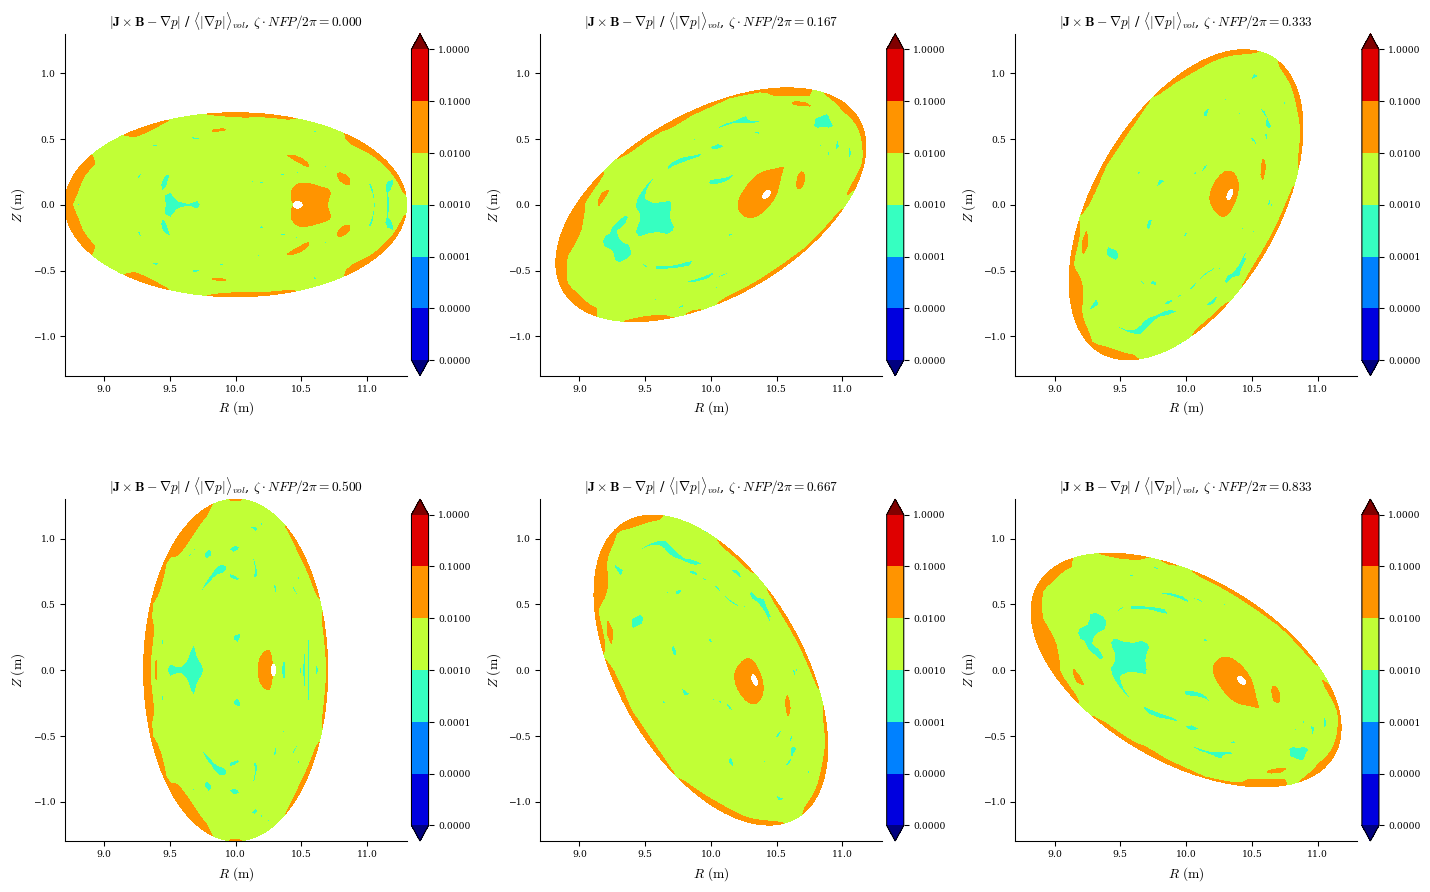

In [7]:
plot_section(eq_fam[-1], "|F|", log=True, norm_F=True);

#### Analysis
While the continuation method took a bit longer to run, it yielded a solution with lower normalized force error across the volume as compared to the solution without the continuation method. For strongly shaped equilibria, using the continuation method usually gives _significantly_ better solutions in _less_ time.

The force error is still relatively high in some parts of the equilibrium (10% when normalized by the pressure gradient). This is because we are using a relatively low resolution just to showcase the code functionality. The force error decreases when solved with higher resolution.

For a more realistic example of using the continuation method to solve a complicated equilibrium, see the [W7-X example input file](https://github.com/PlasmaControl/DESC/blob/master/examples/DESC/W7X).